In [53]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression

In [55]:
#  Import and read the charity_data.csv.
batter_woba_df = pd.read_csv("Resources/batting_for_learning.csv")
batter_woba_df.head()

,player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,est_woba,est_woba_minus_woba_diff,zscore_difference,avg_woba,woba_2023,z_scores_avg_woba
0,408234,2020.666667,502.666667,351.333333,0.26400,0.2460,0.01800,0.36700,0.395667,-0.028667,0.30700,-0.007667,0.139860,0.299333,0.294,-0.937000
1,444482,2020.000000,516.250000,365.500000,0.26950,0.2540,0.01550,0.44850,0.398750,0.049750,0.31500,0.018750,-0.670811,0.333750,0.305,0.171282
2,453568,2020.000000,622.250000,457.500000,0.28475,0.2795,0.00525,0.47700,0.449000,0.028000,0.34325,0.008000,0.280765,0.351250,0.361,0.734815
3,455117,2020.000000,395.750000,252.500000,0.19900,0.1945,0.00450,0.34525,0.334250,0.011000,0.26800,0.003250,-0.308579,0.271250,0.244,-1.841337
4,456781,2020.666667,292.000000,213.666667,0.29800,0.2860,0.01200,0.41500,0.425000,-0.010000,0.33100,-0.001333,0.542901,0.329667,0.345,0.039790


In [57]:
# Drop the 'Name', IDfg, 'wOBA_2023' so it is not part of the classifacation.
batter_woba_class = batter_woba_df.copy()
batter_woba_class.drop(['player_id', 'avg_woba', 'year', 'woba_2023'], axis=1, inplace=True)
batter_woba_class.dropna(axis=1, inplace=True)
batter_woba_class_encoded = batter_woba_class.copy()
batter_woba_class_encoded['zscore_difference'] = batter_woba_class_encoded['zscore_difference'].apply(lambda x: 1 if x > 0 else 0)
batter_woba_class_encoded.head()

,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,est_woba,est_woba_minus_woba_diff,zscore_difference,z_scores_avg_woba
0,502.666667,351.333333,0.26400,0.2460,0.01800,0.36700,0.395667,-0.028667,0.30700,-0.007667,1,-0.937000
1,516.250000,365.500000,0.26950,0.2540,0.01550,0.44850,0.398750,0.049750,0.31500,0.018750,0,0.171282
2,622.250000,457.500000,0.28475,0.2795,0.00525,0.47700,0.449000,0.028000,0.34325,0.008000,1,0.734815
3,395.750000,252.500000,0.19900,0.1945,0.00450,0.34525,0.334250,0.011000,0.26800,0.003250,0,-1.841337
4,292.000000,213.666667,0.29800,0.2860,0.01200,0.41500,0.425000,-0.010000,0.33100,-0.001333,1,0.039790


In [58]:
# Split our preprocessed data into our features and target arrays
X = batter_woba_class_encoded.drop('zscore_difference', axis=1)  # Features (remove the target column)
y = batter_woba_class_encoded['zscore_difference']              # Target

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (195, 11)
X_test shape: (49, 11)
y_train shape: (195,)
y_test shape: (49,)


In [59]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler on the training data
X_scaler = scaler.fit(X_train)

# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print("Selected X_train shape:", X_train_scaled.shape)
print("Selected X_test shape:", X_test_scaled.shape)
print("Selected y_train shape:", y_train.shape)

Selected X_train shape: (195, 11)
Selected X_test shape: (49, 11)
Selected y_train shape: (195,)


In [60]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import cross_val_score, KFold
import shap

# Define your cross-validation strategy (kf)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

imb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgbclassifier', xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.01,
        n_estimators=600,
        subsample=0.5,
        colsample_bytree=0.25,
        objective='binary:logistic',
        random_state=42
    ))
])

# Use cross_val_score with the defined kf
cross_val_scores = cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='recall', cv=kf)

print(cross_val_scores)

imb_pipeline.fit(X_train_scaled, y_train)

y_pred = imb_pipeline.predict(X_test_scaled)

# Fit the pipeline on your training data before creating the SHAP explainer
imb_pipeline.fit(X_train_scaled, y_train)

# Extract the final estimator from the pipeline
final_estimator = imb_pipeline.named_steps['xgbclassifier']

# Create the SHAP explainer with the final estimator
explainer = shap.Explainer(final_estimator, X_train_scaled)

# Calculate SHAP values
shap_values = explainer(X_test_scaled, check_additivity=False)

[0.57894737 0.70588235 0.53333333 0.56521739 0.58823529]


In [61]:
from sklearn.metrics import balanced_accuracy_score

# Assuming you have y_test and y_pred defined
balanced_recall = balanced_accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {balanced_recall:.2f}")

Accuracy: 0.76
Recall: 0.76


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


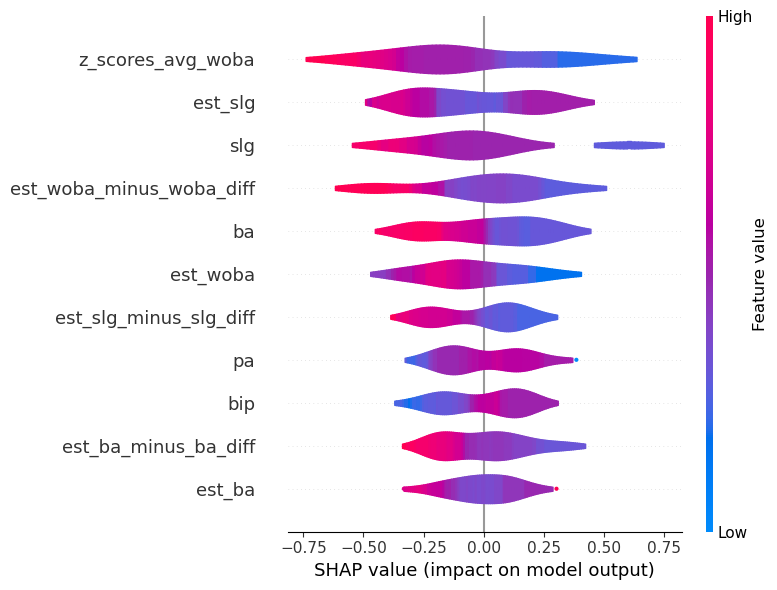

In [62]:
# Create a smaller plot
plt.figure(figsize=(8, 6))

# Generate SHAP summary plot with adjusted figsize
shap.summary_plot(shap_values, X_test_scaled, plot_type='violin', feature_names=X_train.columns, show=False)

# Get the current axes and adjust their size
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_woba_class.png', bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

